# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [2]:
%matplotlib inline

import torch
import torchvision
np = torch._np
import matplotlib.pyplot as plt

import os
import yaml

from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters

# plt.style.use('dark_background')

In [3]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [7]:
if os.path.exists('./synth_data/chaotic_rnn_300'):
    data_dict = read_data('./synth_data/chaotic_rnn_300')
else:
    if not os.path.isdir('./synth_data'):
        os.mkdir('./synth_data/')
    
    from synth_data_chaotic_rnn import generate_data
    data_dict = generate_data(T= 1, dt_rnn= 0.01, dt_cal= 0.01,
                              Ninits= 400, Ntrial= 10, Ncells= 30, trainp= 0.8,
                              tau=0.025, gamma=1.5, maxRate=30, B=20,
                              seed=300, save=True)

train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = torch.Tensor(data_dict['train_rates']).to(device)
valid_truth = torch.tensor(data_dict['valid_rates']).to(device)

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape
train_data[0][1][0] = 1
print(valid_truth.shape)
print(train_data.shape)
print(valid_data.shape)

torch.Size([800, 100, 30])
torch.Size([3200, 100, 30])
torch.Size([800, 100, 30])


## View Example Trial

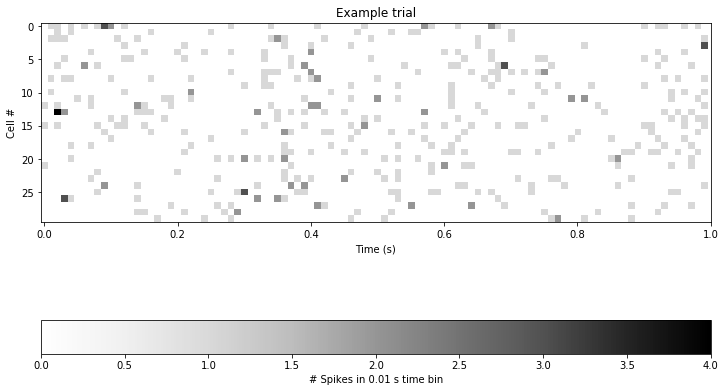

In [4]:
plt.figure(figsize = (12,12))
plt.imshow(data_dict['train_spikes'][1000].T, cmap=plt.cm.Greys)
plt.xticks(np.linspace(0, 100, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='# Spikes in 0.01 s time bin')
plt.title('Example trial');

## View example Ground Truth Firing Rates

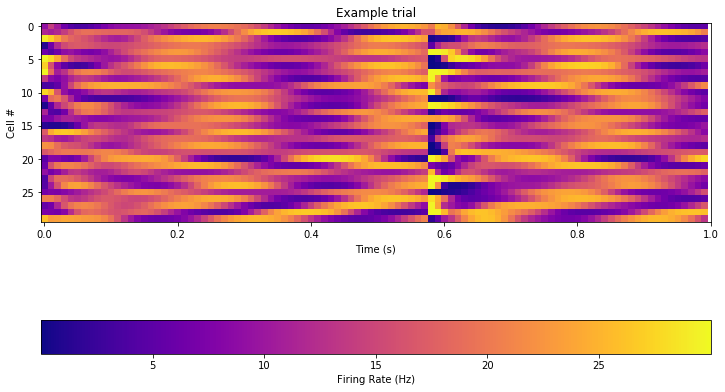

In [5]:
plt.figure(figsize = (12,12))
plt.imshow(data_dict['train_rates'][0].T, cmap=plt.cm.plasma)
plt.xticks(np.linspace(0, 100, 6), ['%.1f'%i for i in np.linspace(0, 1, 6)])
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')
plt.title('Example trial');

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [6]:
hyperparams = load_parameters('./parameters_demo.yaml')
save_parameters(hyperparams)
hyperparams

{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 200,
 'u_dim': 1,
 'factors_dim': 20,
 'g0_encoder_dim': 200,
 'c_encoder_dim': 128,
 'controller_dim': 128,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.95,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [7]:
model = LFADS_Net(inputs_dim = num_cells, T = num_steps, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 8139


#### Pick up where you left off (if you have a recent save) 

In [8]:
# model.load_checkpoint('recent')

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

In [9]:
model.fit(train_ds, valid_ds, max_epochs=800, batch_size=200, use_tensorboard=True,
          train_truth=train_truth, valid_truth=valid_truth)

Beginning training...
Epoch:    1, Step:    16, training loss: 1628.823, validation loss: 2063.107
Epoch:    2, Step:    32, training loss: 1349.878, validation loss: 1820.578
Epoch:    3, Step:    48, training loss: 1335.349, validation loss: 1542.575
Epoch:    4, Step:    64, training loss: 1298.448, validation loss: 1458.347
Epoch:    5, Step:    80, training loss: 1280.780, validation loss: 1473.094
Epoch:    6, Step:    96, training loss: 1274.604, validation loss: 1440.740
Epoch:    7, Step:   112, training loss: 1270.921, validation loss: 1430.353
Epoch:    8, Step:   128, training loss: 1273.812, validation loss: 1428.703
Epoch:    9, Step:   144, training loss: 1272.698, validation loss: 1418.242
Epoch:   10, Step:   160, training loss: 1271.417, validation loss: 1408.794
Epoch:   11, Step:   176, training loss: 1270.395, validation loss: 1401.774
Epoch:   12, Step:   192, training loss: 1270.221, validation loss: 1397.035
Epoch:   13, Step:   208, training loss: 1270.302, val

Epoch:  102, Step:  1632, training loss: 1306.265, validation loss: 1310.382
Epoch:  103, Step:  1648, training loss: 1306.225, validation loss: 1310.578
Epoch:  104, Step:  1664, training loss: 1306.204, validation loss: 1309.862
Epoch:  105, Step:  1680, training loss: 1306.062, validation loss: 1309.429
Epoch:  106, Step:  1696, training loss: 1306.191, validation loss: 1309.383
Epoch:  107, Step:  1712, training loss: 1306.192, validation loss: 1308.730
Epoch:  108, Step:  1728, training loss: 1306.350, validation loss: 1309.177
Learning rate decreased to 0.00513342
Epoch:  109, Step:  1744, training loss: 1306.069, validation loss: 1308.679
Epoch:  110, Step:  1760, training loss: 1306.247, validation loss: 1308.626
Epoch:  111, Step:  1776, training loss: 1306.319, validation loss: 1308.759
Epoch:  112, Step:  1792, training loss: 1306.389, validation loss: 1308.242
Epoch:  113, Step:  1808, training loss: 1306.563, validation loss: 1308.295
Epoch:  114, Step:  1824, training los

Epoch:  205, Step:  3280, training loss: 1305.933, validation loss: 1307.297
Epoch:  206, Step:  3296, training loss: 1306.051, validation loss: 1306.969
Epoch:  207, Step:  3312, training loss: 1305.722, validation loss: 1306.757
Epoch:  208, Step:  3328, training loss: 1305.594, validation loss: 1306.961
Epoch:  209, Step:  3344, training loss: 1305.882, validation loss: 1307.062
Epoch:  210, Step:  3360, training loss: 1305.880, validation loss: 1307.196
Epoch:  211, Step:  3376, training loss: 1305.877, validation loss: 1307.588
Epoch:  212, Step:  3392, training loss: 1305.826, validation loss: 1306.987
Epoch:  213, Step:  3408, training loss: 1305.717, validation loss: 1307.132
Epoch:  214, Step:  3424, training loss: 1305.918, validation loss: 1306.744
Learning rate decreased to 0.00323534
Epoch:  215, Step:  3440, training loss: 1305.679, validation loss: 1307.175
Epoch:  216, Step:  3456, training loss: 1305.663, validation loss: 1306.975
Epoch:  217, Step:  3472, training los

Epoch:  308, Step:  4928, training loss: 1305.441, validation loss: 1306.665
Epoch:  309, Step:  4944, training loss: 1305.433, validation loss: 1306.681
Epoch:  310, Step:  4960, training loss: 1305.357, validation loss: 1306.697
Epoch:  311, Step:  4976, training loss: 1305.286, validation loss: 1306.411
Epoch:  312, Step:  4992, training loss: 1305.434, validation loss: 1306.656
Epoch:  313, Step:  5008, training loss: 1305.395, validation loss: 1306.647
Epoch:  314, Step:  5024, training loss: 1305.285, validation loss: 1306.896
Epoch:  315, Step:  5040, training loss: 1305.432, validation loss: 1306.894
Epoch:  316, Step:  5056, training loss: 1305.317, validation loss: 1306.434
Epoch:  317, Step:  5072, training loss: 1305.489, validation loss: 1306.654
Learning rate decreased to 0.00214639
Epoch:  318, Step:  5088, training loss: 1305.265, validation loss: 1306.514
Epoch:  319, Step:  5104, training loss: 1305.367, validation loss: 1306.312
Epoch:  320, Step:  5120, training los

Epoch:  411, Step:  6576, training loss: 1305.084, validation loss: 1306.485
Epoch:  412, Step:  6592, training loss: 1305.094, validation loss: 1306.373
Epoch:  413, Step:  6608, training loss: 1304.906, validation loss: 1306.841
Epoch:  414, Step:  6624, training loss: 1304.977, validation loss: 1306.308
Epoch:  415, Step:  6640, training loss: 1304.909, validation loss: 1306.478
Epoch:  416, Step:  6656, training loss: 1304.966, validation loss: 1306.613
Epoch:  417, Step:  6672, training loss: 1304.968, validation loss: 1306.465
Epoch:  418, Step:  6688, training loss: 1305.044, validation loss: 1306.274
Epoch:  419, Step:  6704, training loss: 1305.036, validation loss: 1306.308
Epoch:  420, Step:  6720, training loss: 1305.019, validation loss: 1306.495
Epoch:  421, Step:  6736, training loss: 1304.931, validation loss: 1306.320
Epoch:  422, Step:  6752, training loss: 1304.983, validation loss: 1306.286
Epoch:  423, Step:  6768, training loss: 1305.026, validation loss: 1306.702

Epoch:  514, Step:  8224, training loss: 1304.936, validation loss: 1306.299
Epoch:  515, Step:  8240, training loss: 1304.798, validation loss: 1306.468
Epoch:  516, Step:  8256, training loss: 1304.896, validation loss: 1306.187
Epoch:  517, Step:  8272, training loss: 1304.945, validation loss: 1306.078
Learning rate decreased to 0.00099440
Epoch:  518, Step:  8288, training loss: 1304.916, validation loss: 1306.138
Epoch:  519, Step:  8304, training loss: 1304.853, validation loss: 1306.117
Epoch:  520, Step:  8320, training loss: 1304.748, validation loss: 1306.044
Epoch:  521, Step:  8336, training loss: 1304.803, validation loss: 1306.458
Epoch:  522, Step:  8352, training loss: 1304.945, validation loss: 1306.184
Epoch:  523, Step:  8368, training loss: 1304.761, validation loss: 1306.353
Epoch:  524, Step:  8384, training loss: 1304.864, validation loss: 1306.156
Epoch:  525, Step:  8400, training loss: 1304.717, validation loss: 1306.292
Epoch:  526, Step:  8416, training los

Epoch:  616, Step:  9856, training loss: 1304.634, validation loss: 1306.100
Epoch:  617, Step:  9872, training loss: 1304.632, validation loss: 1306.172
Epoch:  618, Step:  9888, training loss: 1304.688, validation loss: 1305.869
Learning rate decreased to 0.00059539
Epoch:  619, Step:  9904, training loss: 1304.638, validation loss: 1306.193
Epoch:  620, Step:  9920, training loss: 1304.639, validation loss: 1306.153
Epoch:  621, Step:  9936, training loss: 1304.580, validation loss: 1306.202
Epoch:  622, Step:  9952, training loss: 1304.564, validation loss: 1305.988
Epoch:  623, Step:  9968, training loss: 1304.729, validation loss: 1306.130
Epoch:  624, Step:  9984, training loss: 1304.751, validation loss: 1305.931
Learning rate decreased to 0.00056562
Epoch:  625, Step: 10000, training loss: 1304.675, validation loss: 1306.161
Epoch:  626, Step: 10016, training loss: 1304.599, validation loss: 1306.049
Epoch:  627, Step: 10032, training loss: 1304.741, validation loss: 1306.143


Epoch:  719, Step: 11504, training loss: 1304.616, validation loss: 1306.124
Epoch:  720, Step: 11520, training loss: 1304.574, validation loss: 1306.036
Epoch:  721, Step: 11536, training loss: 1304.599, validation loss: 1306.033
Epoch:  722, Step: 11552, training loss: 1304.734, validation loss: 1305.935
Learning rate decreased to 0.00039499
Epoch:  723, Step: 11568, training loss: 1304.610, validation loss: 1305.930
Epoch:  724, Step: 11584, training loss: 1304.546, validation loss: 1306.292
Epoch:  725, Step: 11600, training loss: 1304.521, validation loss: 1306.214
Epoch:  726, Step: 11616, training loss: 1304.548, validation loss: 1305.978
Epoch:  727, Step: 11632, training loss: 1304.682, validation loss: 1306.260
Epoch:  728, Step: 11648, training loss: 1304.651, validation loss: 1306.015
Epoch:  729, Step: 11664, training loss: 1304.720, validation loss: 1306.032
Learning rate decreased to 0.00037524
Epoch:  730, Step: 11680, training loss: 1304.675, validation loss: 1306.151


## Load checkpoint with lowest validation error 

In [10]:
model.load_checkpoint('best')

## Plot results summary 

{'traces': <Figure size 576x576 with 12 Axes>,
 'truth': <Figure size 576x576 with 12 Axes>,
 'rsq': <Figure size 432x288 with 1 Axes>,
 'factors': <Figure size 576x576 with 20 Axes>,
 'inputs': <Figure size 576x108 with 1 Axes>}

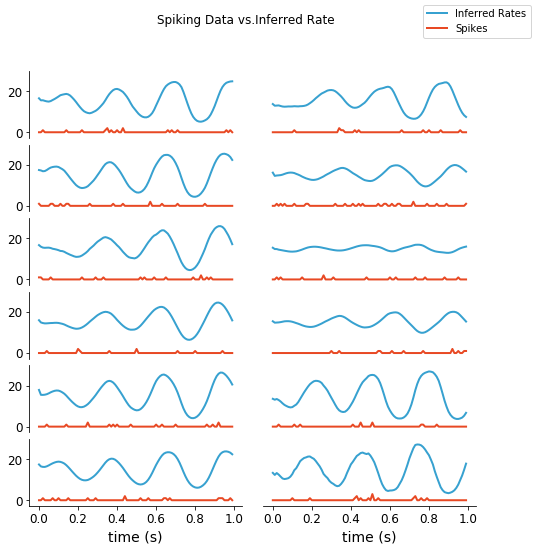

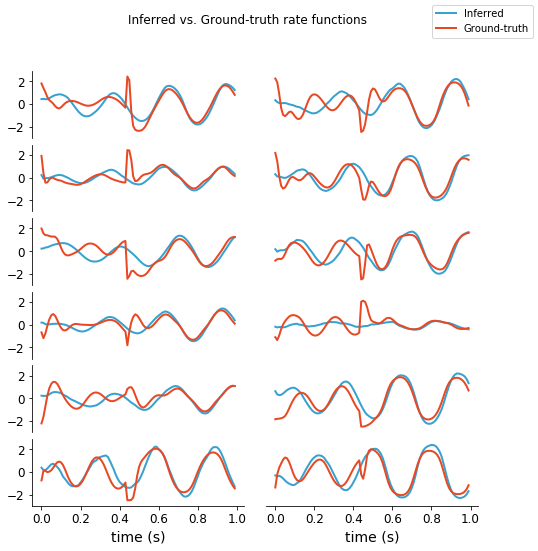

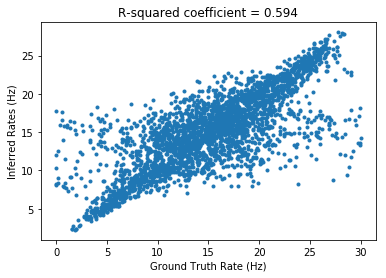

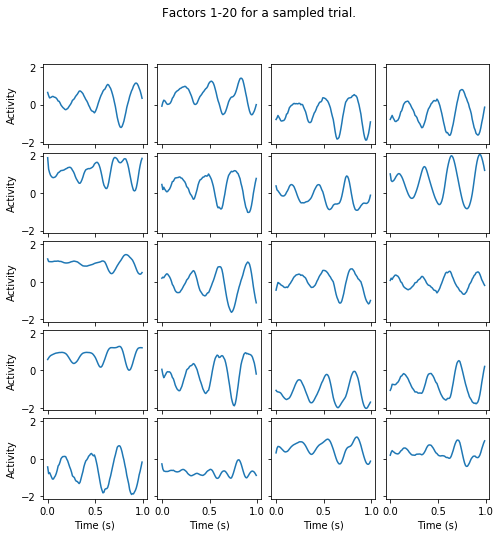

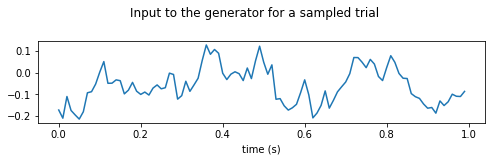

In [11]:
model.plot_summary(data=valid_data, truth=valid_truth)